<a href="https://colab.research.google.com/github/R-Madhuram/UC-BerkeleyCapstone_CreditCardFraudDetection/blob/main/notebooks/3_ensemble_methods/9_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBOOST

## Importing the Libraries

In [ ]:
# Import the libraries
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc,RocCurveDisplay,PrecisionRecallDisplay

In [ ]:
import pandas as pd
import numpy as np
import pickle

In [ ]:
from sklearn import preprocessing
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.model_selection import cross_validate

## Importing helper functions

In [ ]:
# Import the helper functions
# Import the required functions from the helper function file
from helper_functions_ml import createMetricsDF,computeModelMetrics,computeAndPlotMetrics

## Import the Data (training and testing)

In [ ]:
# Read the training data
df_train = pd.read_csv('df.csv')
print(df_train.head())

df_train = df_train.drop('Unnamed: 0', axis=1)
df_train.head(3)
print(df_train.shape)

   Unnamed: 0  TransactionID  isFraud  TransactionDT  TransactionAmt  \
0           0        2987000        0          86400        1.835691   
1           1        2987001        0          86401        1.462398   
2           2        2987002        0          86469        1.770852   
3           3        2987003        0          86499        1.698970   
4           4        2987004        0          86506        1.698970   

   ProductCD  card1  card2  card3  card4  ...  id_36  id_37  id_38  \
0          4  13926   -1.0  150.0      1  ...      2      2      2   
1          4   2755  404.0  150.0      2  ...      2      2      2   
2          4   4663  490.0  150.0      4  ...      2      2      2   
3          4  18132  567.0  150.0      2  ...      2      2      2   
4          1   4497  514.0  150.0      2  ...      0      1      1   

   DeviceType  DeviceInfo  P_emaildomain_addr1_card1  card1_card2  \
0           1        1735                      63363         3655   
1       

In [ ]:
# CP cannot be used to copy file here because numFolds is a variable and hence the filenames will change based on the number of folds.
# instead of using linux CP command we use SHUTIL copy 

# read the K fold train and dev indices

numFolds = 3

import shutil # file copy package. 

srcFileName = 'Classification_Products\train_dev_indices_' + str(numFolds) + '.pickle' 
train_dev_indices_file = 'train_dev_indices_' + str(numFolds) + '.pickle'
# !cp  srcFileName destFileName
shutil.copyfile(srcFileName, train_dev_indices_file)

'train_dev_indices_3.pickle'

In [ ]:
# read the train dev indices file
# train_dev_indices_df = pd.read_csv(train_dev_indices_file)
# train_dev_indices_df.head()

with open(train_dev_indices_file, 'rb') as handle:
    train_dev_indices = pickle.load(handle)
train_dev_indices

{'train': [array([195756, 195757, 195758, ..., 590537, 590538, 590539]),
  array([     0,      1,      2, ..., 590537, 590538, 590539]),
  array([     0,      1,      2, ..., 397410, 397417, 397418])],
 'dev': [array([     0,      1,      2, ..., 221151, 221172, 221182]),
  array([195756, 195757, 195758, ..., 397410, 397417, 397418]),
  array([393481, 393482, 393483, ..., 590537, 590538, 590539])]}

In [ ]:
# Getting dataready
X = df_train.drop(columns = ['isFraud','TransactionID'])
y = df_train['isFraud']

In [ ]:
# List of categorical and numerical columns in merged dataset

## Numerical columns

num_column_lst_final = []
for icol in X.columns:
  if X[icol].dtypes in ['float64', 'int64']:
    num_column_lst_final.append(icol)
print(f"The columns that have numerical features are: '{num_column_lst_final}'")
print(f"The number of columns that have numerical features are: '{len(num_column_lst_final)}'")

print('\n')

## Categorical Columns
cat_column_lst_final = []
for icol in X.columns:
  if X[icol].dtypes in ['object']:
    cat_column_lst_final.append(icol)
print(f"The columns that have categorical features are: '{cat_column_lst_final}'")
print(f"The number of columns that have categorical features are: '{len(cat_column_lst_final)}'")

The columns that have numerical features are: '['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C3', 'C5', 'D1', 'D3', 'D4', 'D8', 'D9', 'D10', 'D13', 'D14', 'M1', 'M2', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V4', 'V6', 'V10', 'V12', 'V14', 'V15', 'V19', 'V23', 'V25', 'V27', 'V35', 'V37', 'V39', 'V44', 'V46', 'V53', 'V55', 'V61', 'V66', 'V75', 'V77', 'V82', 'V86', 'V95', 'V98', 'V99', 'V104', 'V107', 'V108', 'V109', 'V117', 'V118', 'V120', 'V121', 'V123', 'V124', 'V129', 'V135', 'V138', 'V139', 'V141', 'V144', 'V148', 'V161', 'V169', 'V170', 'V172', 'V173', 'V174', 'V184', 'V194', 'V208', 'V209', 'V214', 'V220', 'V221', 'V223', 'V224', 'V226', 'V227', 'V228', 'V238', 'V240', 'V241', 'V250', 'V260', 'V270', 'V281', 'V282', 'V284', 'V286', 'V288', 'V290', 'V300', 'V305', 'V313', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',

## Ensemble model(s)

### Model 1

In [ ]:
# loop through each fold, retrieve the train and dev ids for each fold before running the basic HistBoost Classifier model on each fold
y_pred_train = {}
y_pred_dev = {}

y_pred_train_prob = {}
y_pred_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), 
                   ('clf_xgb', XGBClassifier(n_estimators=150, max_depth=10, booster='gbtree',
                                                                             learning_rate=0.01, objective='binary:logistic',
                                                                             reg_lambda=1, scale_pos_weight=20,
                                                                             
                                                                             tree_method= 'approx'))
                 ])
  pipe.fit(X_train,y_train)

  y_pred_train[i_fold] = pipe.predict(X_train)
  y_pred_dev[i_fold] = pipe.predict(X_dev)

  y_pred_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]


### Model 2

In [ ]:
# loop through each fold, retrieve the train and dev ids for each fold before running the basic HistBoost Classifier model on each fold
y_pred2_train = {}
y_pred2_dev = {}

y_pred2_train_prob = {}
y_pred2_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), 
                   ('clf_xgb', XGBClassifier(n_estimators=150, max_depth=10, booster='gbtree',
                                                                             learning_rate=0.1, objective='binary:logistic',
                                                                             reg_lambda=1, scale_pos_weight=20,max_bin = 512,
                                                                             min_child_weight = 4,
                                                                             tree_method= 'approx'))
                 ])
  pipe.fit(X_train,y_train)

  y_pred2_train[i_fold] = pipe.predict(X_train)
  y_pred2_dev[i_fold] = pipe.predict(X_dev)

  y_pred2_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred2_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]


### Model 3 

In [ ]:
from math import sqrt

y_pred3_train = {}
y_pred3_dev = {}

y_pred3_train_prob = {}
y_pred3_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), 
                   ('clf_xgb', XGBClassifier(max_depth=5,
                                            subsample=0.8,
                                            num_round =100,
                                            eta = 0.2,
                                            gamma =4,
                                            min_child_weight =6,
                                            verbosity =0,
                                            objective ='binary:logistic',
                                            eval_metric ='auc',
                                            scale_pos_weight = scale_pos_weight))
                 ])
  pipe.fit(X_train,y_train)

  y_pred3_train[i_fold] = pipe.predict(X_train)
  y_pred3_dev[i_fold] = pipe.predict(X_dev)

  y_pred3_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred3_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]


### Model 3a 

In [ ]:
from math import sqrt

y_pred3a_train = {}
y_pred3a_dev = {}

y_pred3a_train_prob = {}
y_pred3a_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), 
                   ('clf_xgb', XGBClassifier(max_depth=5,
                                            subsample=0.8,
                                            num_round =100,
                                            eta = 0.2,
                                            gamma =4,
                                            min_child_weight =6,
                                            verbosity =0,
                                            objective ='binary:logistic',
                                            eval_metric ='error',
                                            scale_pos_weight = scale_pos_weight))
                 ])
  pipe.fit(X_train,y_train)

  y_pred3a_train[i_fold] = pipe.predict(X_train)
  y_pred3a_dev[i_fold] = pipe.predict(X_dev)

  y_pred3a_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred3a_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]


### Model 4

In [ ]:
# Install imbalanced learn within the conda environment
!pip install --upgrade imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 KB 4.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
# SMOTE Sampling for the imbalanced dataset
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
from sklearn.model_selection import StratifiedKFold
numFolds = 3
skf = StratifiedKFold(n_splits=numFolds)

In [ ]:
from math import sqrt

y_pred4_train = {}  
y_pred4_dev = {}

y_pred4_train_prob = {}
y_pred4_dev_prob = {}

y_train_folds_smote = {}
y_dev_folds_smote ={}

i_fold=0

for train, dev in skf.split(X_smote, y_smote):
  X_train = X_smote.loc[train,:]
  X_dev = X_smote.loc[dev,:]

  y_train = y_smote[train]
  y_dev = y_smote[dev]

  y_train_folds_smote[i_fold] = y_train
  y_dev_folds_smote[i_fold] = y_dev

  scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), 
                   ('clf_xgb', XGBClassifier( max_depth=7,
                                            #subsample=0.8,
                                            num_round=100,
                                            eta=0.8,
                                            gamma=4,
                                            min_child_weight=6,
                                            silent=0,
                                            objective='binary:logistic',
                                            eval_metric='auc',
                                            tree_method = 'gpu_hist',
                                            reg_lambda = 4,
                                            num_parallel_tree = 10,
                                            scale_pos_weight= scale_pos_weight,
                                            seed=42))
                 ])
  pipe.fit(X_train,y_train)

  y_pred4_train[i_fold] = pipe.predict(X_train)
  y_pred4_dev[i_fold] = pipe.predict(X_dev)

  y_pred4_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred4_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]

  i_fold+=1


[23:12:04] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round", "silent" } are not used.

[23:13:15] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round", "silent" } are not used.

[23:14:35] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round", "silent" } are not used.



### Model 5 (SMOTE Training samples)

In [ ]:
# SMOTE Sampling for the imbalanced dataset
from imblearn.over_sampling import SMOTE
from math import sqrt

smote = SMOTE(random_state=42)

In [ ]:
y_pred5_train = {}  
y_pred5_dev = {}

y_pred5_train_prob = {}
y_pred5_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]

  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]

  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  X_smote, y_smote = smote.fit_resample(X_train, y_train)

  scale_pos_weight = sqrt(np.count_nonzero(y_smote==0)/np.count_nonzero(y_smote))

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe_training_smote = Pipeline([('preprocessor', preprocessor), 
                   ('clf_xgb', XGBClassifier( max_depth=25,
                                            #subsample=0.8,
                                            num_round=1000,
                                            eta=0.4,
                                            gamma=4,
                                            min_child_weight=6,
                                            silent=0,
                                            objective='binary:logistic',
                                            eval_metric='auc',
                                            tree_method = 'gpu_hist',
                                            reg_lambda = 4,
                                            num_parallel_tree = 100,
                                            scale_pos_weight= scale_pos_weight,
                                            seed=42))
                 ])
  pipe_training_smote.fit(X_smote,y_smote)

  y_pred5_train[i_fold] = pipe_training_smote.predict(X_train)
  y_pred5_dev[i_fold] = pipe_training_smote.predict(X_dev)

  y_pred5_train_prob[i_fold] = pipe_training_smote.predict_proba(X_train)[:,1]
  y_pred5_dev_prob[i_fold] = pipe_training_smote.predict_proba(X_dev)[:,1]

  i_fold+=1


[20:29:57] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round", "silent" } are not used.

[20:40:21] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round", "silent" } are not used.

[20:51:32] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round", "silent" } are not used.



## Evaluation of the model(s)

##### Model 1

In [ ]:
thresholds = np.arange(0, 1, .05)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined a

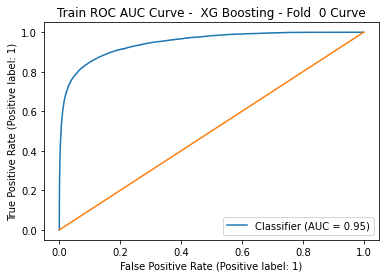

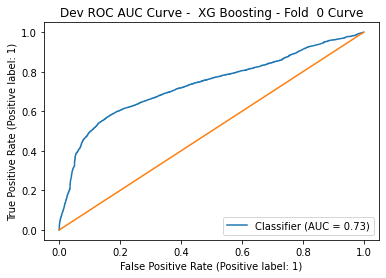

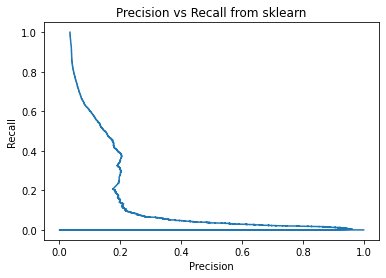

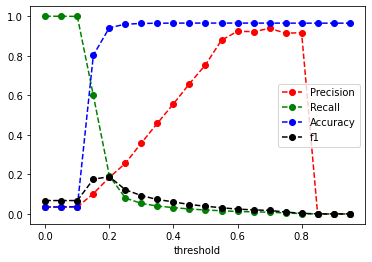

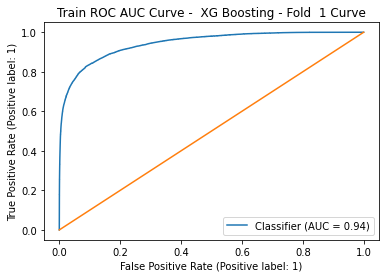

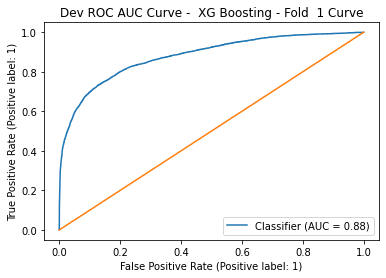

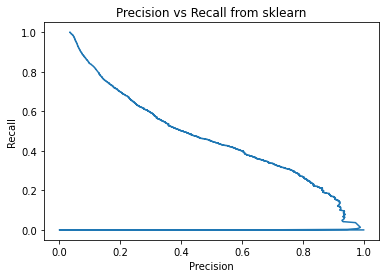

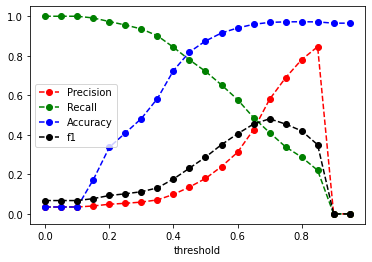

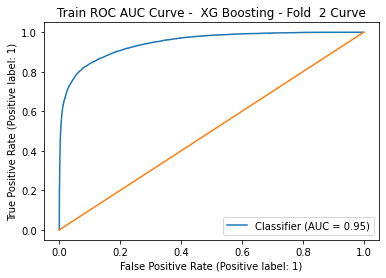

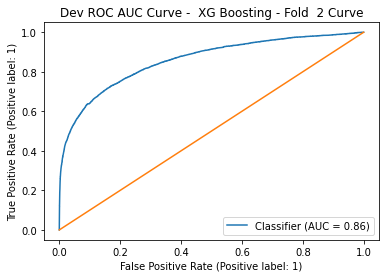

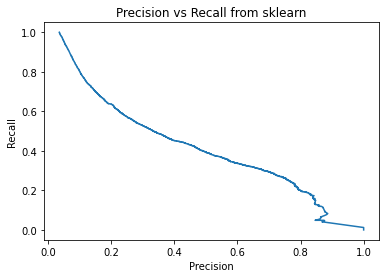

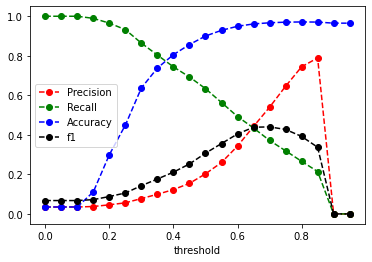

In [ ]:
# Basic XGBoost
xgb_metrics_DF = []
for i_fold in range(0,numFolds): 
 xgb_metrics_DF.append(computeAndPlotMetrics(y_pred_train[i_fold],y_pred_train_prob[i_fold],
                              y_pred_dev[i_fold],y_pred_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'XG Boosting - Fold  ' + str(i_fold) ))


### Model 2

In [ ]:
# Basic XGBoost
xgb2_metrics_DF = []
for i_fold in range(0,numFolds): 
 xgb2_metrics_DF.append(computeAndPlotMetrics(y_pred2_train[i_fold],y_pred2_train_prob[i_fold],
                              y_pred2_dev[i_fold],y_pred2_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'XG Boosting - Fold  ' + str(i_fold) ))


### Model 3

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined a

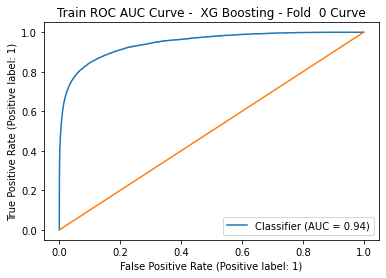

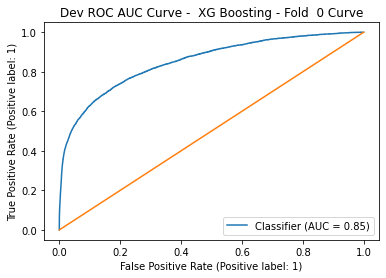

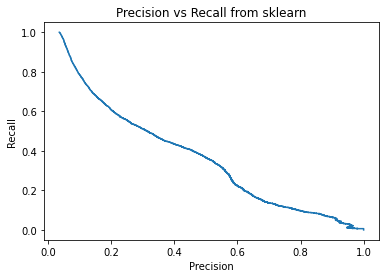

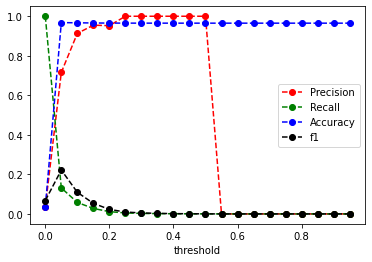

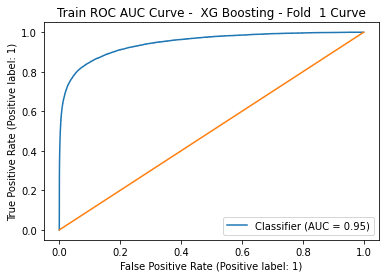

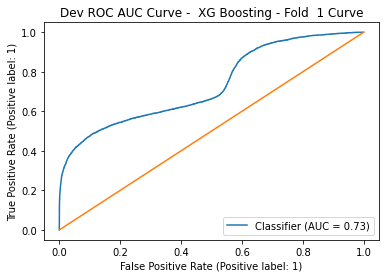

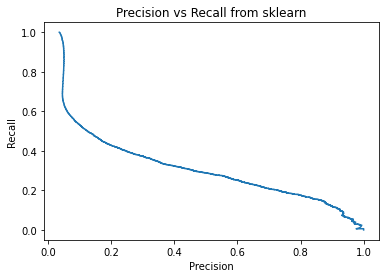

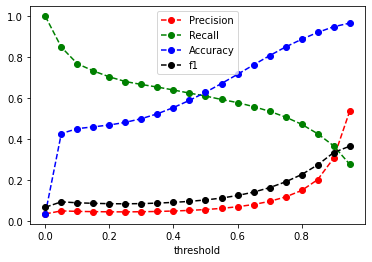

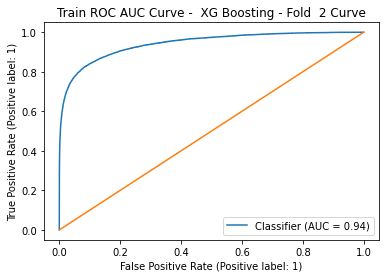

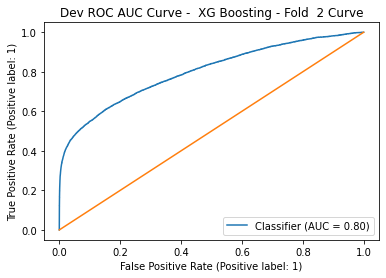

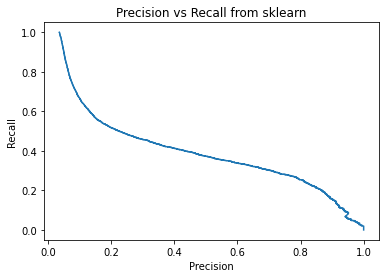

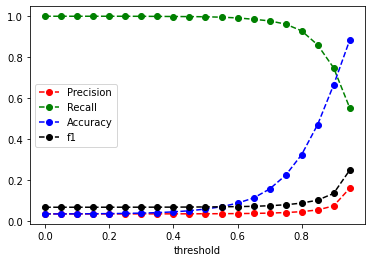

In [ ]:
xgb3_metrics_DF = []
for i_fold in range(0,numFolds): 
 xgb3_metrics_DF.append(computeAndPlotMetrics(y_pred3_train[i_fold],y_pred3_train_prob[i_fold],
                              y_pred3_dev[i_fold],y_pred3_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'XG Boosting - Fold  ' + str(i_fold) ))


### Model 3a

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined a

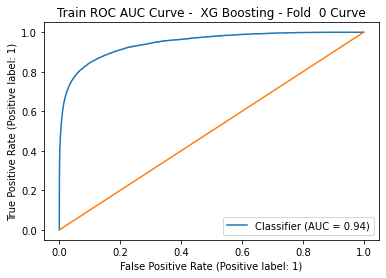

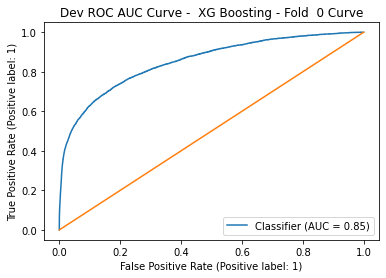

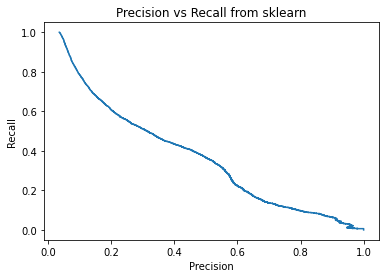

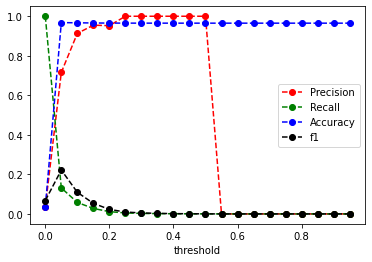

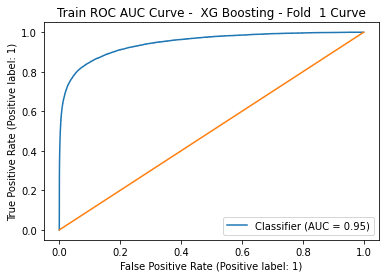

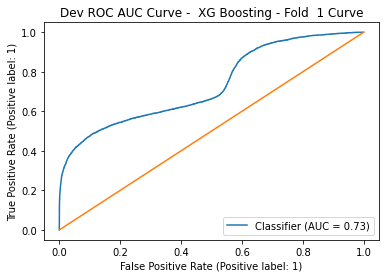

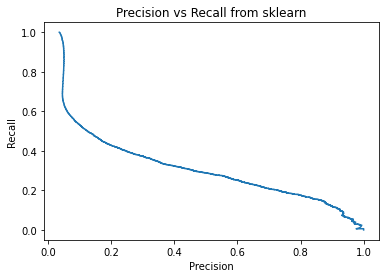

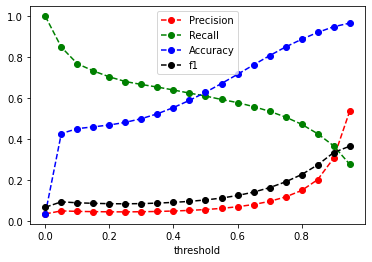

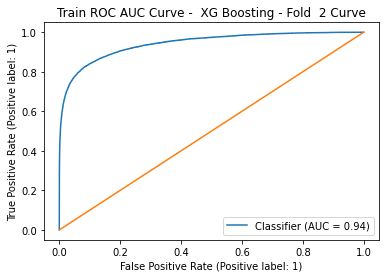

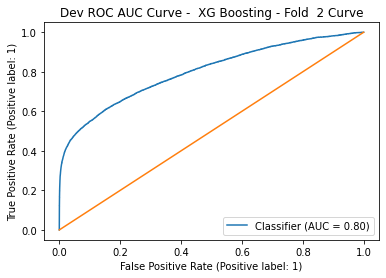

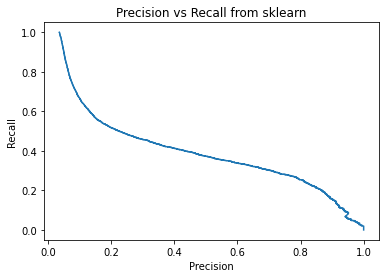

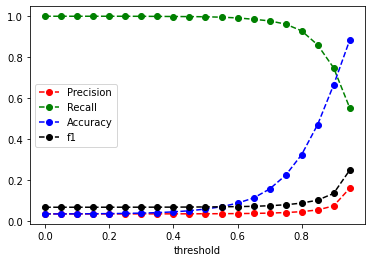

In [ ]:
xgb3a_metrics_DF = []
for i_fold in range(0,numFolds): 
 xgb3a_metrics_DF.append(computeAndPlotMetrics(y_pred3a_train[i_fold],y_pred3a_train_prob[i_fold],
                              y_pred3a_dev[i_fold],y_pred3a_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'XG Boosting - Fold  ' + str(i_fold) ))


### Model 4

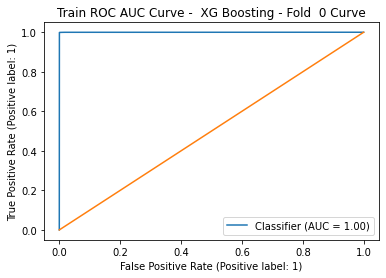

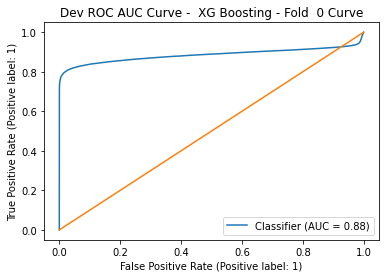

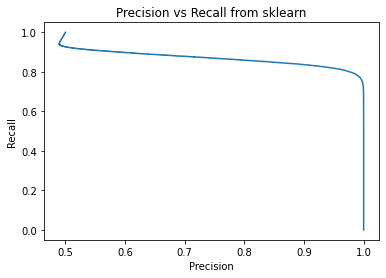

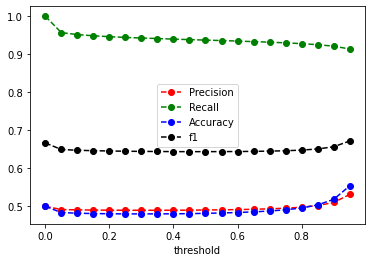

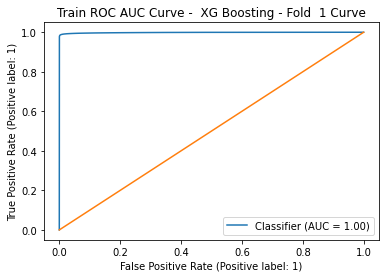

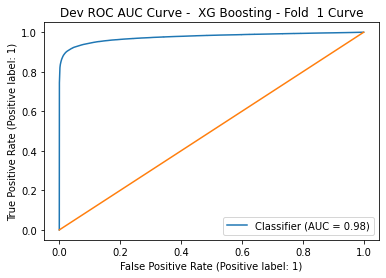

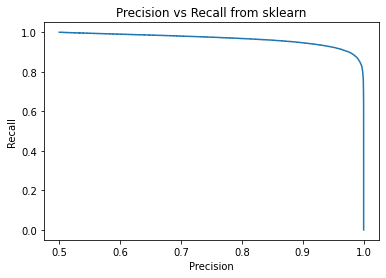

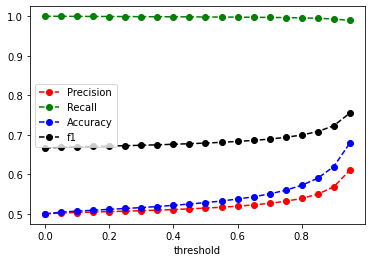

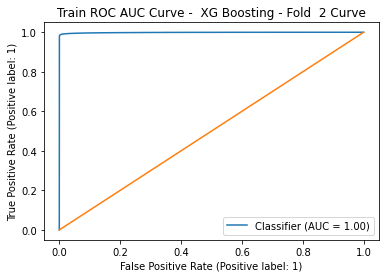

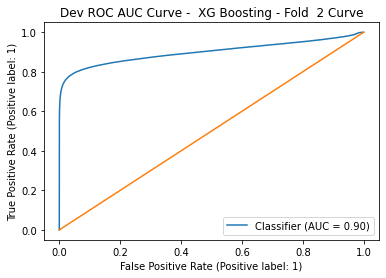

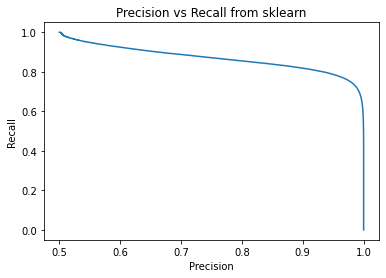

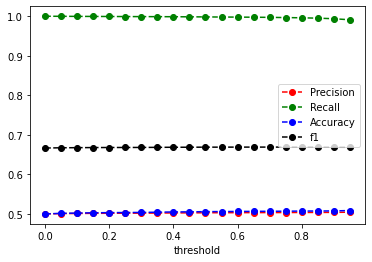

In [ ]:
xgb4_metrics_DF = []
for i_fold in range(0,numFolds): 
 xgb4_metrics_DF.append(computeAndPlotMetrics(y_pred4_train[i_fold],y_pred4_train_prob[i_fold],
                              y_pred4_dev[i_fold],y_pred4_dev_prob[i_fold],
                                  y_dev_folds_smote[i_fold],y_train_folds_smote[i_fold],thresholds,
                                  'XG Boosting - Fold  ' + str(i_fold) ))


### Model 5 

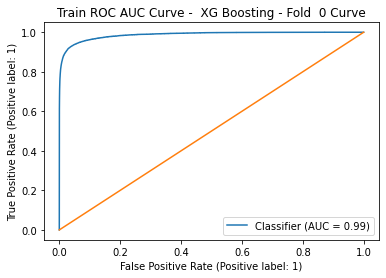

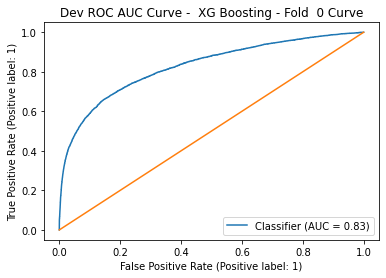

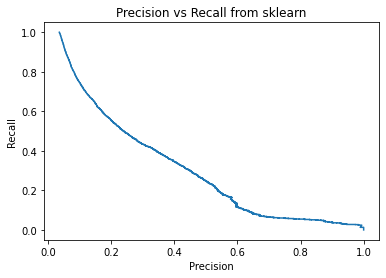

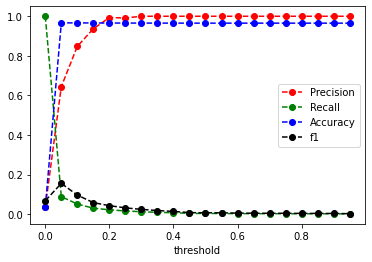

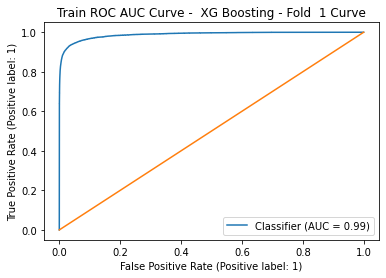

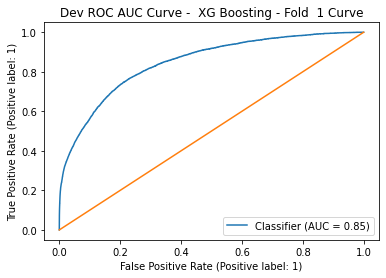

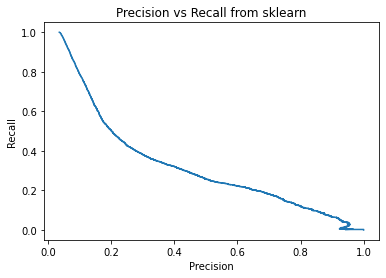

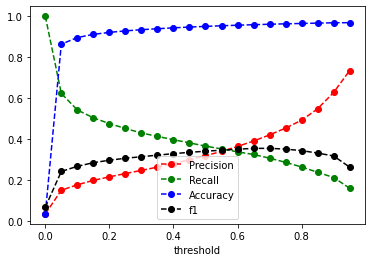

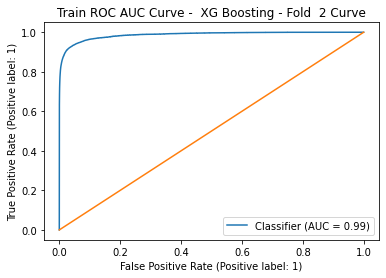

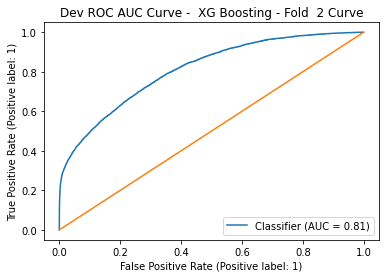

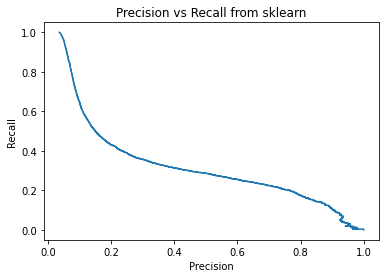

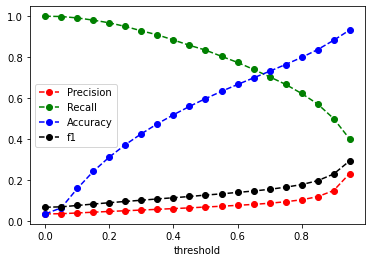

In [ ]:
xgb5_metrics_DF = []
for i_fold in range(0,numFolds): 
 xgb5_metrics_DF.append(computeAndPlotMetrics(y_pred5_train[i_fold],y_pred5_train_prob[i_fold],
                              y_pred5_dev[i_fold],y_pred5_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'XG Boosting - Fold  ' + str(i_fold) ))


# Summary

In [ ]:
xgb_metrics_DF

In [ ]:
xgb2_metrics_DF

In [ ]:
xgb3_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.975633  0.631534   0.670555  0.596806       0.944998
 1  development  0.965013  0.000290   1.000000  0.000145       0.851820,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.977579  0.659308   0.703890  0.620036       0.945384
 1  development  0.628737  0.103200   0.056364  0.610482       0.732304,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.976792  0.645179   0.693695  0.603005       0.942105
 1  development  0.058777  0.069030   0.035752  0.997386       0.800037]

In [ ]:
xgb3a_metrics_DF

In [ ]:
xgb4_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.998925  0.998924   0.999805  0.998044       0.999973
 1  development  0.481564  0.643857   0.490355  0.937260       0.884515,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.991313  0.991254   0.997951  0.984647       0.998595
 1  development  0.528569  0.679211   0.514733  0.998168       0.976078,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.991780  0.991727   0.998094  0.985442       0.998775
 1  development  0.505746  0.668856   0.502895  0.998310       0.899584]

In [ ]:
xgb5_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.988781  0.815381   0.960985  0.708094       0.986891
 1  development  0.965130  0.006944   1.000000  0.003484       0.827664,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.989248  0.823882   0.965010  0.718766       0.988094
 1  development  0.950510  0.341044   0.319276  0.365999       0.846666,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.988826  0.815610   0.965083  0.706228       0.986524
 1  development  0.597813  0.126816   0.068620  0.834761       0.810634]


In this notebook, we utilized the Xtreme Gradient Boosting technique to enhance ROC-AUC scores compared to simpler classification models like Logistic Regression and Decision Trees.

Initially, we started with the default method, but Models 1, 2, and 3a either produced poor results or caused the RAM to crash due to computational expenses. These models have been retained for informational purposes, although their results have not been presented here.

Upon further analysis, Model 5 emerged as the most promising, exhibiting the best results with a comparable AUC score to other high-performing models and a significantly higher recall score. Model 4 also demonstrated comparable performance, with a higher ROC-AUC score and recall score.

However, it's important to note that Model 4 (SMOTE sampled model), which achieved the highest ROC-AUC score, likely suffered from overfitting. The synthetic data points generated by SMOTE were present in both the training and development sets, potentially causing the model to overlearn these samples and inflate its score.

This overfitting issue was further highlighted in Model 5, where SMOTE sampling was applied only to the training set. Despite this adjustment, the ROC-AUC score remained comparable to other models, suggesting a more reliable performance.

Therefore, we select Model 5 for further analysis, considering its robust performance metrics and potential avoidance of overfitting issues.